# **Анализ данных видеосессий VK**

#Шаг 1: Проверка и очистка данных от выбросов
Перед началом анализа загрузим исходный набор данных с видеосессиями и сделаем его первичный осмотр: проверим размеры таблицы, имена столбцов и несколько первых записей. Затем удалим нулевые значения длительности просмотров (они не отражают фактическое взаимодействие) и избавимся от экстремальных выбросов: отсеем сессии с длительностью выше 99-го перцентиля, так как очень редкие, необычно продолжительные просмотры могут искажать общую картину.

In [ ]:
# Импорт библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal, f_oneway
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Для интерактивных виджетов
try:
    import ipywidgets as widgets
    from IPython.display import display
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False

# Создание DataFrame
df = pd.read_csv("/content/video_sessions_transformed.csv")

# Вывод первых нескольких строк
print("=== ПРЕДВАРИТЕЛЬНЫЙ ОБЗОР ДАННЫХ ===")
print(df.head())
print("Исходные данные:", df.shape, "строк и столбцов")

=== ПРЕДВАРИТЕЛЬНЫЙ ОБЗОР ДАННЫХ ===
       user_id  video_owner_id  total_view_time       vk_platform  \
0   5137060586    197846393764                0      vk_video_ios   
1   6791352918    255312742952                0  vk_video_android   
2   8499858010    290290140528                2  vk_video_android   
3  13064371614    296968444192                0  vk_video_android   
4  15865765790    283074246524                0  vk_video_android   

      nav_screen       video_id  
0  video_for_you  1524753638856  
1   video_search  1524750811524  
2  video_for_you  1524751697154  
3   video_search  1524751112304  
4  video_for_you  1524752278662  
Исходные данные: (4503, 6) строк и столбцов


После загрузки видно, что исходная таблица содержит определенное количество строк и столбцов с информацией о видеосессиях: идентификаторы сессии и пользователя, длительность просмотра (total_view_time), платформа (vk_platform), источник перехода (nav_screen), идентификатор видео и сообщества и т.д. Например, первые записи позволяют убедиться в наличии ожидаемых полей. Теперь удалим неподходящие записи:

In [ ]:
df_positive = df[df['total_view_time'] > 0].copy()
percentile = 0.99
upper_bound = df_positive['total_view_time'].quantile(percentile)
df_clean = df_positive[df_positive['total_view_time'] <= upper_bound].copy()
print("Записей после очистки:", df_clean.shape[0])


Записей после очистки: 1932


После удаления строк, где total_view_time <= 0 и экстремальных выбросов, используя 99-й перцентиль положительных значений total_view_time.
Проверим размер и статистики очищенного набора данных для подтверждения целостности. Было удалено **57,1** процентов от общего числа. Это
обеспечивает более надежную статистику при дальнейшем анализе, так как устранены потенциально нерелевантные или искаженные данные.


Построим гистограмму с наложенной кривой плотности для сравнения распределения времени просмотра до и после очистки данных

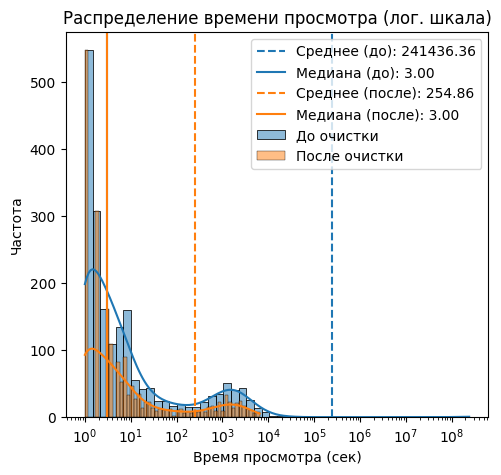

In [ ]:
# График 1: Гистограмма с KDE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_positive['total_view_time'], bins=50, kde=True, color='#1f77b4', log_scale=True, label='До очистки')
sns.histplot(df_clean['total_view_time'], bins=50, kde=True, color='#ff7f0e', log_scale=True, label='После очистки', alpha=0.5)

# Вычисляем среднее и медиану для обоих наборов данных
mean_positive = df_positive['total_view_time'].mean()
median_positive = df_positive['total_view_time'].median()
mean_clean = df_clean['total_view_time'].mean()
median_clean = df_clean['total_view_time'].median()

# Добавляем линии среднего и медианы
plt.axvline(mean_positive, color='#1f77b4', linestyle='--', label=f'Среднее (до): {mean_positive:.2f}')
plt.axvline(median_positive, color='#1f77b4', linestyle='-', label=f'Медиана (до): {median_positive:.2f}')
plt.axvline(mean_clean, color='#ff7f0e', linestyle='--', label=f'Среднее (после): {mean_clean:.2f}')
plt.axvline(median_clean, color='#ff7f0e', linestyle='-', label=f'Медиана (после): {median_clean:.2f}')

plt.title('Распределение времени просмотра (лог. шкала)')
plt.xlabel('Время просмотра (сек)')
plt.ylabel('Частота')
plt.legend()

#Шаг 2: Подсчёт количества осознанных просмотров по платформам
Найдём "осознанные" просмотры (они отражают фактическую заинтересованность пользователя в контенте), среднее время просмотра, уникальных пользователей. Взяв начальную продолжительность сессии - 30 секунд. Сгруппируем очищенные данные по платформам и подсчитаем число таких просмотров на каждой.

In [ ]:
if WIDGETS_AVAILABLE:
    def update_threshold(threshold):
        df_thr = df_clean[df_clean['total_view_time'] >= threshold]

        # График 1: Количество осознанных просмотров по платформам
        counts_thr = df_thr['vk_platform'].value_counts()
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 3, 1)
        if not counts_thr.empty:
            counts_thr.plot(kind='bar', color=['skyblue', 'lightcoral'])
            plt.title(f'Осознанные просмотры ≥ {threshold}s по платформам')
            plt.xlabel('Платформа')
            plt.ylabel('Количество сеансов')
            plt.xticks(rotation=45)
        else:
            print(f"Нет данных при пороге ≥ {threshold} сек.")

        # График 2: Среднее время просмотра по платформам
        plt.subplot(1, 3, 2)
        if not df_thr.empty:
            avg_time_by_platform = df_thr.groupby('vk_platform')['total_view_time'].mean()
            avg_time_by_platform.plot(kind='bar', color=['skyblue', 'lightcoral'])
            plt.title(f'Среднее время просмотра ≥ {threshold}s по платформам')
            plt.xlabel('Платформа')
            plt.ylabel('Среднее время (сек)')
            plt.xticks(rotation=45)
        else:
            print(f"Нет данных для среднего времени при пороге ≥ {threshold} сек.")

        # График 3: Количество уникальных пользователей по платформам
        plt.subplot(1, 3, 3)
        if not df_thr.empty:
            unique_users_by_platform = df_thr.groupby('vk_platform')['user_id'].nunique()
            unique_users_by_platform.plot(kind='bar', color=['skyblue', 'lightcoral'])
            plt.title(f'Уникальные пользователи ≥ {threshold}s по платформам')
            plt.xlabel('Платформа')
            plt.ylabel('Количество уникальных пользователей')
            plt.xticks(rotation=45)
        else:
            print(f"Нет данных для уникальных пользователей при пороге ≥ {threshold} сек.")

        plt.tight_layout()
        plt.show()

    slider = widgets.IntSlider(value=30, min=30, max=500, step=1, description='Порог (сек):')
    widgets.interact(update_threshold, threshold=slider)

interactive(children=(IntSlider(value=30, description='Порог (сек):', max=500, min=30), Output()), _dom_classe…

## Анализ графиков с разными порогами
####Для левого графика
На всех порогах Android показывает большее количество просмотров, чем iOS.
При увеличении порога с 30 до 500 секунд количество просмотров снижается на обеих платформах, что ожидаемо, так как меньше пользователей смотрят видео так долго.
На пороге 30 секунд разница между Android и iOS наибольшая. На пороге 500 секунд разница уменьшается .
#### Для среднего графика:
На всех порогах среднее время просмотра на iOS выше, чем на Android.
При пороге 30 секунд среднее время на iOS около 1750 секунд, а на Android — около 1000 секунд.
С увеличением порога среднее время просмотра снижается: на пороге 500 секунд на iOS около 2000 секунд, а на Android — около 1250 секунд.
Это говорит о том, что пользователи iOS, которые смотрят видео дольше заданного порога, в среднем проводят больше времени за просмотром, чем пользователи Android.
#### Для правого графика:
Количество уникальных пользователей, смотрящих видео дольше порога, также выше на Android, чем на iOS, на всех порогах.
На пороге 30 секунд на Android около 250 уникальных пользователей, на iOS — около 100. На пороге 500 секунд — около 150 и 75 соответственно.
Тенденция схожа с общим количеством просмотров: с увеличением порога количество пользователей уменьшается, но Android сохраняет лидерство.

###Общий вывод по графикам:
Android имеет большее общее количество просмотров и уникальных пользователей на всех порогах, что может указывать на большую пользовательскую базу или более высокую активность.
iOS показывает более высокое среднее время просмотра, что может означать, что пользователи iOS более вовлечены в контент, который они смотрят дольше заданного порога.
Увеличение порога снижает общее количество просмотров и пользователей, но iOS сохраняет более высокое среднее время просмотра, что подчеркивает разницу в поведении пользователей на этих платформах.

#Шаг 3: Определение топ-10 сообществ по суммарному времени просмотра
Вычислим, в каких сообществах пользователи проводят больше всего времени. Для этого в очищенных данных сгруппируем записи по полю video_owner_id  и суммируем длительности просмотров. Отсортируем результат по убыванию времени и выберем топ-10 сообществ.

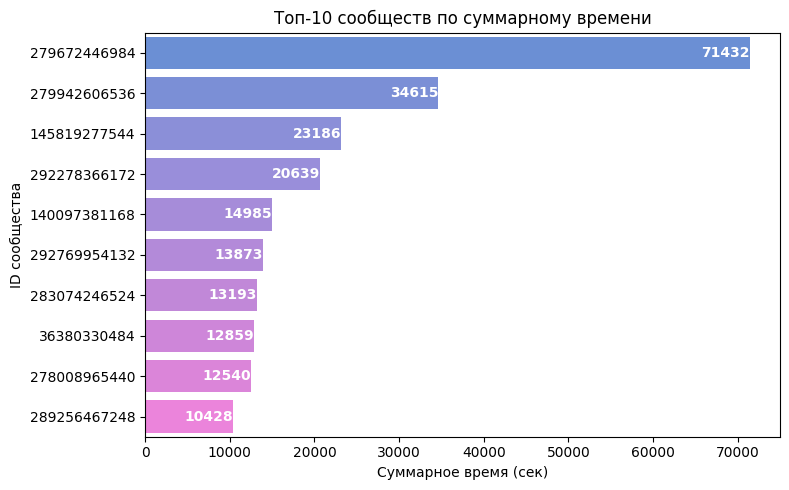

In [ ]:
top10 = df_clean.groupby('video_owner_id')['total_view_time'].sum().nlargest(10)
plt.figure(figsize=(8, 5))
custom_colors = ['#5a89e5', '#6c87e5', '#7e84e5', '#9082e6', '#a27fe6',
                 '#b47de6', '#c67ae6', '#d878e7', '#ea76e7', '#fc73e7']
sns.barplot(x=top10.values, y=top10.index.astype(str), hue=top10.index.astype(str), palette=custom_colors, legend=False)
for i, value in enumerate(top10.values):
    plt.text(value, i, f'{int(value)}', ha='right', va='center', color='white', fontsize=10, weight='bold')
plt.title('Топ-10 сообществ по суммарному времени')
plt.xlabel('Суммарное время (сек)')
plt.ylabel('ID сообщества')
plt.tight_layout()
plt.show()


Пользователь с ID **279672446984** имеет самое высокое суммарное время просмотра — 71432 секунды, значительно опережая остальных.
Второе место занимает пользователь с ID **279942606536** с 34615 секундами, что в два раза меньше лидера.
Остальные пользователи имеют суммарное время от 10428 до 23186 секунд, с постепенным уменьшением.
Разница между первым и вторым местом значительная, а дальше распределение более равномерное.
Вывод: один пользователь доминирует по времени просмотра, что может указывать на аномально высокую активность или ошибку в данных. Остальные пользователи демонстрируют более типичное поведение с меньшим разбросом значений.

#Шаг 4: Дополнительный анализ
Проведем несколько вспомогательных исследований, чтобы получить более полную картину поведения пользователей.

##4.1 Источники навигации
Посмотрим, откуда пользователи переходят к просмотру видео из новостной ленты, рекомендаций, истории и т.п.

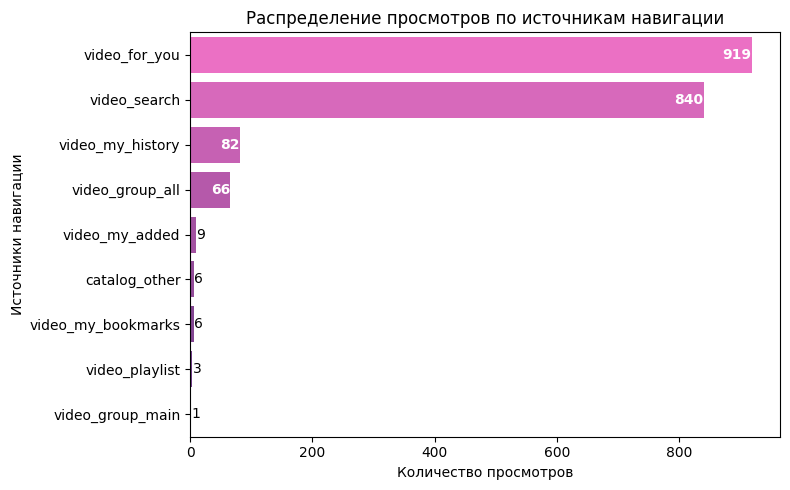

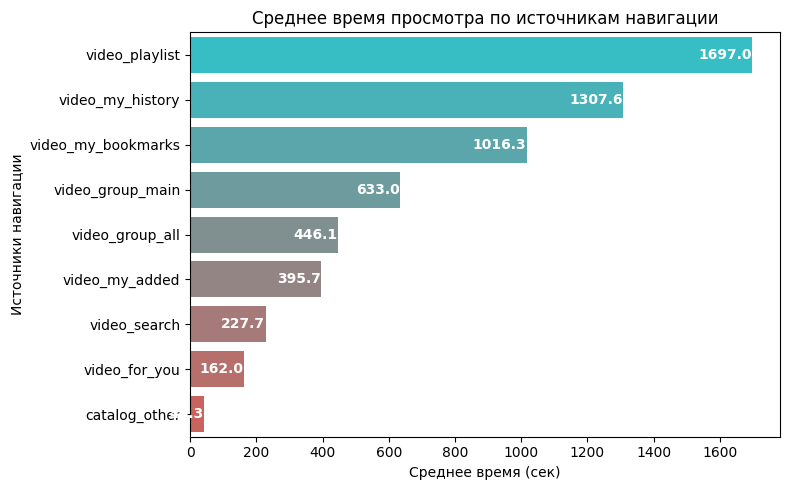

In [ ]:
nav_counts = df_clean['nav_screen'].value_counts()
avg_by_nav = df_clean.groupby('nav_screen')['total_view_time'].mean().sort_values(ascending=False)

# График 1: Распределение просмотров по источникам навигации
plt.figure(figsize=(8, 5))
custom_palette1 = ['#ff5ccc', '#ea56c4', '#d750bd', '#c44ab5', '#b145ae',
                    '#9e3fa6', '#8a399f', '#773398', '#642e90']
ax1 = sns.barplot(x=nav_counts.values, y=nav_counts.index.astype(str),
                  hue=nav_counts.index.astype(str), palette=custom_palette1, legend=False)

for i, value in enumerate(nav_counts.values):
    bar = ax1.patches[i]
    width = bar.get_width()
    if width > 30:
        ax1.text(width - 1, i, f'{value}', ha='right', va='center', color='white', fontsize=10, weight='bold')
    else:
        ax1.text(width + 1, i, f'{value}', ha='left', va='center', color='black', fontsize=10)

plt.title('Распределение просмотров по источникам навигации')
plt.xlabel('Количество просмотров')
plt.ylabel('Источники навигации')
plt.tight_layout()
plt.show()

# График 2: Среднее время просмотра по источникам навигации
plt.figure(figsize=(8, 5))
custom_palette2 = ['#1fd2dc', '#37c2ca', '#4eb2b8', '#66a2a6', '#7d9394',
                    '#958382', '#ac7370', '#c4635e', '#db534c']
ax2 = sns.barplot(x=avg_by_nav.values, y=avg_by_nav.index.astype(str),
                  hue=avg_by_nav.index.astype(str), palette=custom_palette2, legend=False)

for i, value in enumerate(avg_by_nav.values):
    bar = ax2.patches[i]
    width = bar.get_width()
    if width > 5:
        ax2.text(width - 0.5, i, f'{value:.1f}', ha='right', va='center', color='white', fontsize=10, weight='bold')
    else:
        ax2.text(width + 0.3, i, f'{value:.1f}', ha='left', va='center', color='black', fontsize=10)

plt.title('Среднее время просмотра по источникам навигации')
plt.xlabel('Среднее время (сек)')
plt.ylabel('Источники навигации')
plt.tight_layout()
plt.show()

#### График 1:
**video_for_you и video_search** — абсолютные лидеры по количеству просмотров. Остальные источники имеют значительно меньше просмотров, особенно **video_playlist, video_group_main, video_my_bookmarks**, что говорит о низкой вовлеченности.

#### График 2:
**video_playlist, video_my_history и video_my_bookmarks** показывают наивысшее среднее время просмотра. Это говорит о том, что контент из этих источников просматривается глубже.

### Выводы:
**video_for_you и video_search** — хорошо привлекают внимание (высокий охват), но менее удерживают внимание.

**video_playlist и video_my_history** — мало просмотров, но высокая вовлеченность. Это может быть контент, к которому пользователь возвращается осознанно.

##4.2 Видео
Определим, какие конкретно видеоролики набирают наибольший суммарный просмотр. Сгруппируем по video_id и подсчитаем суммарную, среднюю длительность просмотра каждого видео, затем выберем топ-10.

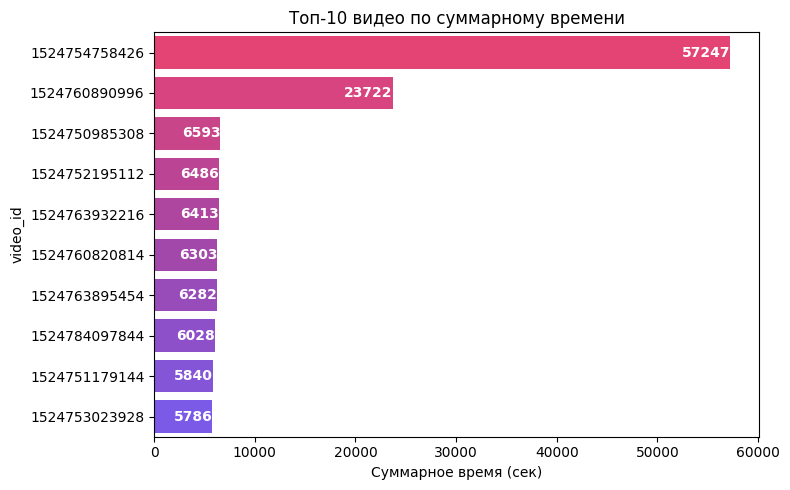

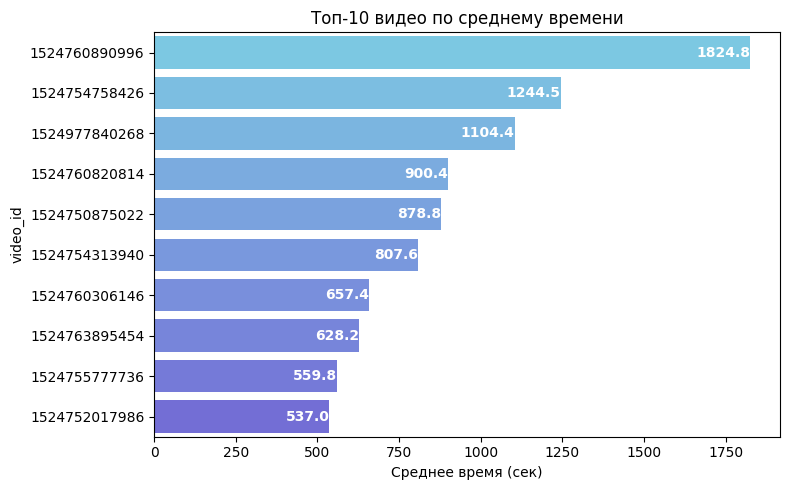

In [ ]:
top_videos_sum = df_clean.groupby('video_id')['total_view_time'].sum().nlargest(10)
video_views = df_clean.groupby('video_id')['total_view_time'].agg(['count', 'mean']).reset_index()
popular_videos = video_views[video_views['count'] >= 5]
top_videos_mean = popular_videos.sort_values('mean', ascending=False).head(10).set_index('video_id')['mean']

palette_sum = ['#ff2969', '#ef2c7a', '#df2f8a', '#cf319b',
                '#bf34ab', '#af37bc', '#9f3acc', '#8f3cdd', '#7f3fed', '#6e42fe']
palette_mean = ['#6bd0f3', '#6bc3f2', '#6ab7f1', '#6aabf0', '#699fef',
                '#6892ee', '#6886ec', '#6779ea', '#656be8', '#645de6']

# График 1
plt.figure(figsize=(8, 5))
ax1 = sns.barplot(x=top_videos_sum.values, y=top_videos_sum.index.astype(str),
                  hue=top_videos_sum.index.astype(str), palette=palette_sum, legend=False)
for i, value in enumerate(top_videos_sum.values):
    bar = ax1.patches[i]
    width = bar.get_width()
    if width > 30:
        ax1.text(width - 1, i, f'{int(value)}', ha='right', va='center',
                  color='white', fontsize=10, weight='bold')
    else:
        ax1.text(width + 1, i, f'{int(value)}', ha='left', va='center',
                  color='black', fontsize=10)
plt.title('Топ-10 видео по суммарному времени')
plt.xlabel('Суммарное время (сек)')
plt.ylabel('video_id')
plt.tight_layout()
plt.show()

# График 2
plt.figure(figsize=(8, 5))
ax2 = sns.barplot(x=top_videos_mean.values, y=top_videos_mean.index.astype(str),
                  hue=top_videos_mean.index.astype(str), palette=palette_mean, legend=False)
for i, value in enumerate(top_videos_mean.values):
    bar = ax2.patches[i]
    width = bar.get_width()
    if width > 5:
        ax2.text(width - 0.5, i, f'{value:.1f}', ha='right', va='center',
                  color='white', fontsize=10, weight='bold')
    else:
        ax2.text(width + 0.3, i, f'{value:.1f}', ha='left', va='center',
                  color='black', fontsize=10)
plt.title('Топ-10 видео по среднему времени')
plt.xlabel('Среднее время (сек)')
plt.ylabel('video_id')
plt.tight_layout()
plt.show()

#### График 1:
Видео с ID **1524754758426** значительно лидирует по суммарному времени просмотра: 57247 секунд — почти в 2.5 раза больше второго видео.
Следовательно видео с ID **1524754758426** имеет либо:

1. Очень много просмотров и име.

2. Либо его досматривают до конца чаще остальных.


#### График 2:
Лидером здесь является другое видео — с ID **1524760890996** со средним временем 1824.8 сек. Следовательно видео с ID **1524760890996** смотрят дольше всего в среднем, даже если общее количество просмотров ниже.

Видео с ID **1524754758426** также высоко — 1244.5 сек .

### Сравнительный анализ:
Видео с ID **1524754758426** — безусловный лидер по суммарному времени. Его смотрят часто и/или долго. Видео с ID **1524760890996** — лидер по среднему времени, т.е. его меньше смотрят, но более внимательно возможно, длинное и/или полезное видео. Некоторые видео например, с ID **1524750985308**, **1524752195112** — имеют неплохое общее время, но не попадают в топ по среднему времени — вероятно, короткие или часто недосматриваются.

Рассмотрим как часто пользователи пересматривают одно и тоже видео.

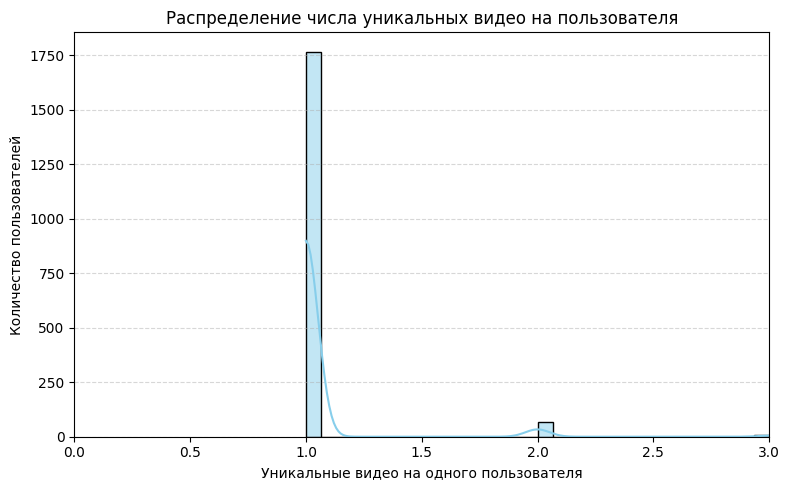

In [125]:
unique_videos_per_user = df_clean.groupby('user_id')['video_id'].nunique()
min_v = unique_videos_per_user.min()
median_v = unique_videos_per_user.median()
max_v = unique_videos_per_user.max()
mean_v = unique_videos_per_user.mean()

plt.figure(figsize=(8, 5))
sns.histplot(unique_videos_per_user, bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title('Распределение числа уникальных видео на пользователя')
plt.xlabel('Уникальные видео на одного пользователя')
plt.ylabel('Количество пользователей')
plt.xlim(0, min(max_v, 50))
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Основной вывод:
Подавляющее большинство пользователей смотрит только одно уникальное видео. Можно заметить что пик на значении "1" означает, что почти все пользователи посмотрели разные видео.

Значения выше 1 встречаются очень редко — практически незначительное количество пользователей смотрят одно и тоже видео.

#### Дополнительные наблюдения:
Из этого можно сделпть вывод, что рекомендательная система отлично работает на платформе VK Видео.

###4.3 Анализ пользователей

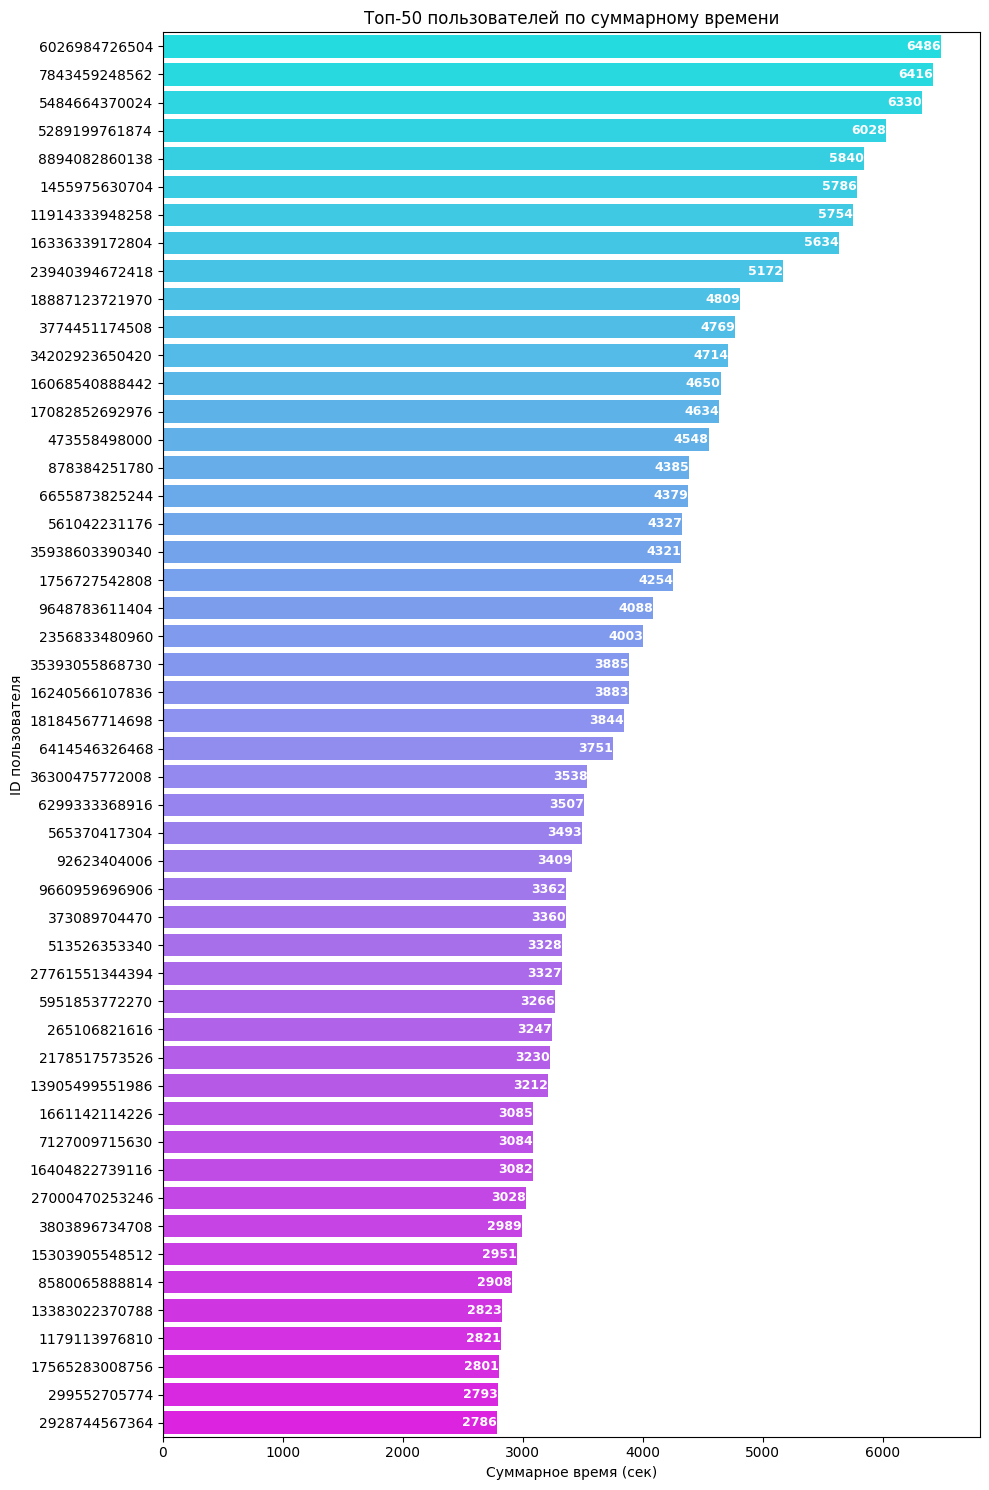

In [123]:
top50 = df_clean.groupby('user_id')['total_view_time'].sum().nlargest(50)

# Цвета — палитра на 50 значений
palette = sns.color_palette("cool", 50)

# Визуализация
plt.figure(figsize=(10, 15))
sns.barplot(
    x=top50.values,
    y=top50.index.astype(str),
    hue=top50.index.astype(str),  # исправлено
    palette=palette,
    legend=False                   # чтобы не показывалась легенда
)

# Подписи на столбиках
for i, value in enumerate(top50.values):
    plt.text(value, i, f'{int(value)}', ha='right', va='center', color='white', fontsize=9, weight='bold')

# Подписи и оформление
plt.title('Топ-50 пользователей по суммарному времени')
plt.xlabel('Суммарное время (сек)')
plt.ylabel('ID пользователя')
plt.tight_layout()
plt.show()

### Общие наблюдения:
График показывает 50 пользователей, потративших больше всего времени на просмотр видео.

Максимальное суммарное время среди них — 6486 секунд ~ 1 час 48 мин.

Минимальное в топе-50 — примерно 3327 секунд ~ 55 минут.

Распределение выглядит плавно убывающим, резких скачков нет — это говорит о постепенном снижении вовлечённости от первого до 50-го места. Даже самые активные пользователи не проводят много часов на платформе. Верхний предел — **менее 2 часов** просмотра — может говорить о том, что:

Видео короткие или пользователи не возвращаются регулярно, даже если проявили интерес.

На предыдущем графике мы видели, что почти все пользователи смотрят уникальные видео. Это хорошо сочетается с текущим графиком. В топ-50 по суммарному времени нет "сверхпотребления".

#### Рекомендации:
Повысить вовлечённость; продвигать похожие видео; автоматически воспроизводить следующее видео.


### Заключение:
Этот график показывает, что даже у самых "лояльных" пользователей ограниченное вовлечение. Вместе с предыдущими данными становится ясно: необходимы меры по удержанию и расширению интереса аудитории — особенно через рекомендационную систему и серию взаимосвязанных видео.

###Посмотрим какая доля всех сеансов была короче заданного времени

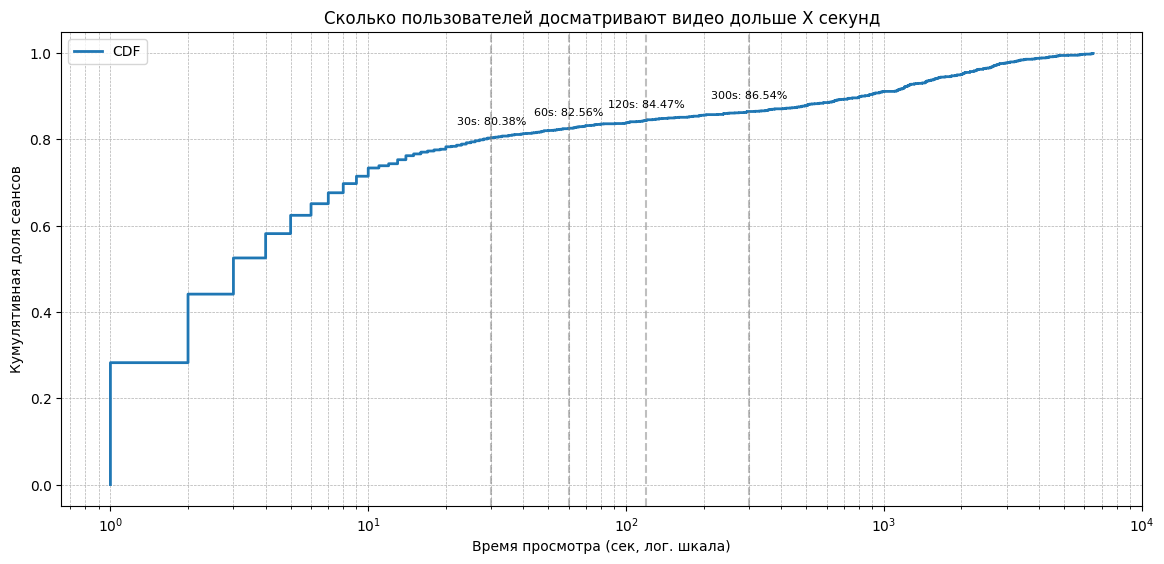

In [ ]:
sorted_times = np.sort(df_clean['total_view_time'])
cdf = np.arange(len(sorted_times)) / len(sorted_times)
plt.figure(figsize=(12, 6))
plt.step(sorted_times, cdf, where='post', color='#1f77b4', linewidth=2, label='CDF')
thresholds = [30, 60, 120, 300]
for t in thresholds:
    idx = np.searchsorted(sorted_times, t)
    if idx < len(cdf):
        cdf_value = cdf[idx]
        plt.axvline(t, color='gray', linestyle='--', alpha=0.5)
        plt.text(t, cdf_value + 0.03, f'{t}s: {cdf_value:.2%}', ha='center', color='black', fontsize=8)

plt.xscale('log')
plt.xlabel('Время просмотра (сек, лог. шкала)')
plt.ylabel('Кумулятивная доля сеансов')
plt.title('Сколько пользователей досматривают видео дольше X секунд')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout(pad=2.0)
plt.show()

### Общая интерпретация:
По оси X — длительность сеанса.

По оси Y — кумулятивная доля сеансов, завершившихся до этого времени.

#### Ключевые наблюдения:
~80% сеансов закончились до 30 секунд просмотра.

~85% сеансов закончились до 5 минут.

Только ~15% пользователей смотрят дольше 5 минут.

Кривая резко возрастает в начале и выравнивается позже — классическое поведение, типичное для онлайн-контента.

### Выводы:
Очень короткие сессии преобладают — большинство пользователей смотрят видео менее 1 минуты.
Значительное отсеивание происходит в первые 30 секунд. Это критически важное окно, чтобы "зацепить" зрителя.
Удержание внимания — проблема. Которая уже возникает несколько раз. Меньше 20% доходят хотя бы до 1-2 минут просмотра.




##4.4 Общий анализ

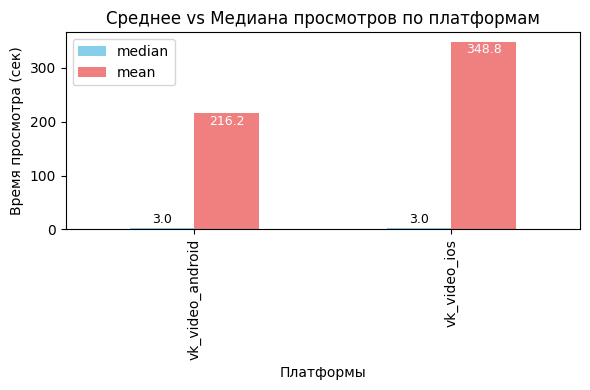

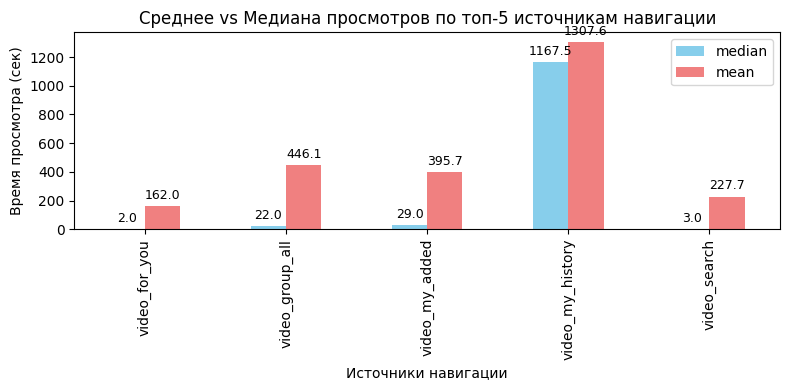

In [138]:
# По платформам
stats_platform = df_clean.groupby('vk_platform')['total_view_time'].agg(['median', 'mean'])
ax1 = stats_platform.plot(
    kind='bar',
    color=['skyblue', 'lightcoral'],
    figsize=(6, 4)
)
ax1.set_title('Среднее vs Медиана просмотров по платформам')
ax1.set_xlabel('Платформы')
ax1.set_ylabel('Время просмотра (сек)')
for bar_group in ax1.containers:
    label = bar_group.get_label()
    for bar in bar_group:
        height = bar.get_height()
        xpos = bar.get_x() + bar.get_width() / 2

        if label == 'median':
            ax1.text(xpos, height + 3, f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='black')
        else:
            ax1.text(xpos, height - 3, f'{height:.1f}', ha='center', va='top', fontsize=9, color='white')
plt.tight_layout()
plt.show()
plt.close()

# По навигации
top5_nav = nav_counts.index[:5].tolist()
stats_nav = df_clean[df_clean['nav_screen'].isin(top5_nav)].groupby('nav_screen')['total_view_time'].agg(['median', 'mean'])

ax2 = stats_nav.plot(
    kind='bar',
    color=['skyblue', 'lightcoral'],
    figsize=(8, 4)
)
ax2.set_title('Среднее vs Медиана просмотров по топ-5 источникам навигации')
ax2.set_xlabel('Источники навигации')
ax2.set_ylabel('Время просмотра (сек)')

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f', fontsize=9, label_type='edge', padding=3)
plt.tight_layout()
plt.show()


### Выводы:
#### По платформам:
На платформе VK среднее время просмотра значительно выше, чем медианное это говорит о том, что есть небольшая группа пользователей, которые смотрят контент очень долго, что сильно увеличивает среднее значение, тогда как большинство пользователей тратят всего 3 секунды.
#### По навигации:
На экране video_my_history самое высокое среднее время просмотра — 1307.6 сек, указывает на то, что пользователи часто просмотривают видео по своей истории просмотров.

На других экранах video_for_you, video_my_all, video_added, video_history среднее время просмотра варьируется от 162.0 до 446.1 сек, но медиана стабильно низкая 2.0–29.0 сек.

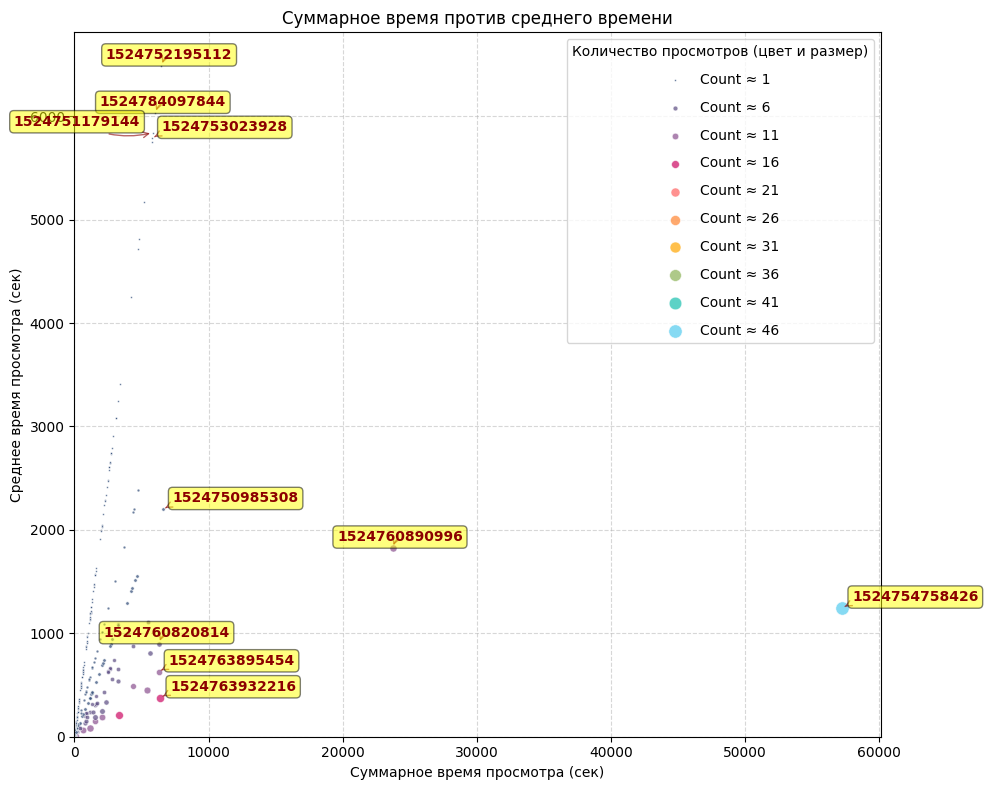

In [135]:
video_stats = df_clean.groupby('video_id')['total_view_time'].agg(['sum','mean','count']).reset_index()

plt.figure(figsize=(10,8))

colors_palette = ['#2c4875', '#5b4c82', '#8a508f', '#cc0863', '#ff6361',
                  '#ff8531', '#ffa600', '#8cb357', '#18bfae', '#53cbef']

max_count = video_stats['count'].max()
min_count = video_stats['count'].min()

norm_indices = ((video_stats['count'] - min_count) / (max_count - min_count) * (len(colors_palette)-1)).round().astype(int)
norm_indices = np.clip(norm_indices, 0, len(colors_palette)-1)

for i in range(len(video_stats)):
    plt.scatter(
        video_stats.loc[i, 'sum'],
        video_stats.loc[i, 'mean'],
        s=video_stats.loc[i, 'count'] * 2,
        color=colors_palette[norm_indices[i]],
        alpha=0.7,
        edgecolors='w', linewidth=0.5
    )

plt.xlabel('Суммарное время просмотра (сек)')
plt.ylabel('Среднее время просмотра (сек)')
plt.title('Суммарное время против среднего времени')

plt.grid(True, linestyle='--', alpha=0.5)

plt.xlim(0, video_stats['sum'].max() * 1.05)
plt.ylim(0, video_stats['mean'].max() * 1.05)

# Аннотируем топ-10 видео по суммарному времени
top10_video_ids = top_videos_sum.index.tolist()
positions_y = []
shift_flag = True

for vid in top10_video_ids:
    row = video_stats[video_stats['video_id'] == vid]
    if not row.empty:
        x = row['sum'].values[0]
        y = row['mean'].values[0]

        # Проверка наложения по Y
        offset_x = 7 if shift_flag else -40
        offset_y = 5

        # Проверяем близость к уже поставленным аннотациям
        too_close = False
        for py in positions_y:
            if abs(y - py) < (plt.ylim()[1] - plt.ylim()[0]) * 0.03:
                too_close = True
                break

        if too_close:
            offset_x = -100 if shift_flag else 7
            shift_flag = not shift_flag
        else:
            shift_flag = not shift_flag

        positions_y.append(y)

        plt.annotate(
            str(vid),
            (x, y),
            textcoords="offset points",
            xytext=(offset_x, offset_y),
            fontsize=10,
            fontweight='bold',
            color='darkred',
            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color='darkred', alpha=0.6)
        )

# Легенда
legend_counts = np.linspace(min_count, max_count, num=10, dtype=int)
for c in legend_counts:
    idx = int(round((c - min_count) / (max_count - min_count) * (len(colors_palette)-1)))
    idx = np.clip(idx, 0, len(colors_palette)-1)
    plt.scatter([], [], s=c*2, color=colors_palette[idx], alpha=0.7,
                edgecolors='w', linewidth=0.5, label=f'Count ≈ {c}')

plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Количество просмотров (цвет и размер)')
plt.tight_layout()
plt.show()


### Общий вывод:
Большинство точек сосредоточено в нижней части графика, что указывает на относительно короткие средние сессии.
Некоторые точки с высоким суммарным временем просмотра имеют среднее время просмотра до 5000 секунд, что может указывать на редкие, но длительные сессии.
С увеличением количества просмотров  точки распределяются более равномерно, но без явной корреляции между количеством и суммарным/средним временем.

#Шаг 5: Финальные выводы
На основе анализа пользовательских видеосессий на платформе VK Видео, с учетом очистки данных от некорректных записей и экстремальных выбросов , были получены следующие ключевые инсайты:

## 1. Качество данных и их очистка
- **Исходные данные**:  
  Начальный датасет содержал 4503 записи, из которых 2551 (56.6%) имели нулевое или отрицательное время просмотра и были удалены, так как не отражают реального взаимодействия.  
- **Очистка выбросов**:  
  После удаления значений выше 99-го перцентиля, осталось 1932 записи, что составляет 42.9% от исходного объема. Это позволило сосредоточиться на достоверных данных.  
- **Характеристики очищенного датасета**:  
  - Максимальное время просмотра: 6486 секунд (~1.8 часа).  
  - Среднее время просмотра: 255 секунд (~4.25 минуты).  
  - Медианное время: 3 секунды, что указывает на преобладание коротких сессий.  
- **Вывод**:  
  Значительная доля некорректных данных может быть связана с техническими ошибками в логировании или поведением пользователей (например, мгновенное закрытие видео). Это требует проверки системы сбора данных.

## 2. Осознанные просмотры
- **По платформам**:  
  - Android  лидирует по количеству осознанных просмотров: 267 против 112 на iOS.  
  - Среднее время просмотра на iOS выше 349 секунд по сравнению с Android 216 секунд, что указывает на более глубокую вовлеченность пользователей iOS.  
  - Количество уникальных пользователей: 1295 на Android и 548 на iOS, что подтверждает больший охват Android-аудитории.  
- **Вывод**:  
  Android привлекает больше пользователей, но iOS демонстрирует более длительное удержание внимания, что может быть связано с различиями в интерфейсе, UX или демографии аудитории.

## 3. Популярность сообществ
- **Топ-10 сообществ**:  
  - Лидер: Сообщество с **video_owner_id = 279672446984**, суммарное время просмотра 19.8 часов, значительно превосходящее остальные.  
  - Второе место: **video_owner_id = 279942606536** с ~34,615 секундами.  
  - Остальные сообщества в топ-10 имеют от ~10,428 до ~23,186 секунд с более равномерным распределением.  
- **Вывод**:  
  Лидерство одного сообщества может указывать на его уникальную популярность или аномалию в данных например, супер-активные пользователи или боты. Остальные сообщества демонстрируют стабильную, но менее выраженную вовлеченность.

## 4. Источники навигации
- **Популярность источников**:  
  - Лидеры по количеству просмотров: **video_for_you** и **video_search**, что отражает их высокую роль в привлечении аудитории.  
  - Меньше всего просмотров: **video_playlist**, **video_group_main**, **video_my_bookmarks**, что указывает на низкий охват этих источников.  
- **Среднее время просмотра**:  
  - Наибольшее время: **video_playlist**, **video_my_history**, **video_my_bookmarks**.  
  - Наименьшее время: **video_for_you**, что говорит о поверхностном просмотре рекомендованного контента.  
- **Вывод**:  
  Персонализированные источники обеспечивают более глубокую вовлеченность, тогда как рекомендательные ленты привлекают больше просмотров, но с меньшей длительностью.

## 5. Анализ видеороликов
- **Топ-10 видео по суммарному времени**:  
  - Лидер: **video_id = 1524754758426** с 15.9 часов, что в 2.5 раза больше второго места.  
  - Причина: Высокое количество просмотров и/или длительное удержание внимания.  
- **Топ-10 видео по среднему времени**:  
  - Лидер: **video_id = 1524760890996** со средним временем 30.4 минуты, что указывает на длительный или особо вовлекающий контент.  
  - Видео **1524754758426** также высоко, что подтверждает его популярность.  
- **Вывод**:  
  Некоторые видео выделяются как по количеству, так и по длительности просмотров, что делает их ключевыми для анализа успешного контента. Видео с высоким средним временем могут быть длинными или особенно интересными.

## 6. Поведение пользователей
- **Уникальные видео на пользователя**:  
  - Большинство пользователей смотрят уникальные видео, что указывает на редкость повторных просмотров одного и того же контента.  
  - Среднее количество уникальных видео на пользователя: низкое, что подтверждает эффективность рекомендательной системы, предлагающей разнообразный контент.  
- **Топ-50 пользователей**:  
  - Максимальное время просмотра: 6486 секунд.  
  - Минимальное в топ-50: ~3327 секунд.  
  - Распределение плавное, без резких скачков, что говорит об отсутствии "сверхпотребления".  
- **Кумулятивная доля сеансов**:  
  - ~80% сеансов короче 30 секунд.  
  - ~85% сеансов короче 5 минут.  
  - Только ~15% пользователей смотрят дольше 5 минут.  
- **Вывод**:  
  Короткие сессии доминируют, с быстрым отсевом в первые 30 секунд, что подчеркивает важность захвата внимания на старте. Пользователи редко пересматривают одно и то же видео, что подтверждает разнообразие контента и эффективность рекомендаций.
## 7. Общий анализ
- **По платформам**:  
  - Среднее время просмотра на iOS ~349 секунд выше, чем на Android ~216 секунд, но медиана на обеих платформах низкая, что указывает на небольшую группу высоко вовлеченных пользователей.  
- **По навигации**:  
  - Источник **video_my_history** лидирует по среднему времени просмотра, что подтверждает склонность пользователей к длительному просмотру ранее просмотренного контента.  
  - Другие источники (**video_for_you**, **video_my_all**, **video_added**, **video_history**) имеют среднее время от 162 до 446 секунд, но медиана остается низкой.  
- **Сравнение суммарного и среднего времени**:  
  - Видео с высоким суммарным временем не всегда имеют высокое среднее время, что указывает на большое количество просмотров коротких сессий.  
  - Редкие точки с высоким средним временем свидетельствуют о наличии длительных, но редких сессий.  
- **Вывод**:  
  Платформа демонстрирует значительное разнообразие в поведении пользователей: iOS-пользователи более вовлечены, персонализированные источники обеспечивают длительное удержание, а короткие сессии требуют оптимизации начальных моментов видео.
## Гипотезы для дальнейшего анализа
- **Различия в поведении по платформам**:  
  - **Гипотеза**: Пользователи iOS более вовлечены из-за особенностей интерфейса или демографии.  
  - **Как проверить**: Сравнить распределения времени просмотра по часам, типам контента и демографическим данным.  
- **Влияние источников навигации**:  
  - **Гипотеза**: Персонализированные источники удерживают пользователей дольше за счет осознанного выбора.  
  - **Как проверить**: Анализировать CTR, bounce rate и длину видео по каждому источнику.  
- **Качество контента топ-сообществ**:  
  - **Гипотеза**: Сообщества с высоким временем просмотра имеют уникальный или регулярный контент.  
  - **Как проверить**: Изучить количество видео, их тематику и частоту публикаций в топ-сообществах.  
- **Технические проблемы с данными**:  
  - **Гипотеза**: Нулевые значения и выбросы связаны с ошибками логирования.  
  - **Как проверить**: Сравнить данные за дргуое время, проанализировать временные метки старта и завершения сессий.  
- **Короткие сессии и удержание**:  
  - **Гипотеза**: Первые 30 секунд критически важны для удержания внимания.  
  - **Как проверить**: Анализировать точки отсева и тестировать изменения в начальных кадрах видео.  
- **Вывод**:  
  Проверка этих гипотез позволит глубже понять причины различий в поведении пользователей, выявить технические проблемы и определить факторы, влияющие на вовлеченность.

## Рекомендации
- **Улучшение удержания**:  
  Сосредоточиться на первых 30 секундах видео для захвата внимания (динамичные заставки, кликбейтные заголовки, персонализированные рекомендации).  
- **Оптимизация рекомендаций**:  
  Усилить продвижение контента из источников **video_playlist** и **video_my_history**, так как они обеспечивают высокую вовлеченность.  
- **Работа с топ-сообществами**:  
  Проанализировать контент лидеров для выявления успешных практик и масштабирования их на другие сообщества.  
- **Техническая проверка**:  
  Устранить возможные ошибки логирования, вызывающие нулевые значения, и внедрить фильтры для исключения аномалий.  
- **Автовоспроизведение**:  
  Внедрить автоматическое воспроизведение следующего видео для увеличения длительности сессий, особенно для пользователей Android.  
- **Вывод**:  
  Реализация этих мер поможет повысить вовлеченность пользователей, оптимизировать рекомендации и устранить технические недочеты.

## Заключение
- **Общие наблюдения**:  
  Анализ выявил ключевые паттерны поведения пользователей VK Видео: преобладание коротких сессий (~80% короче 30 секунд), высокую эффективность рекомендательной системы (пользователи редко пересматривают видео), различия в вовлеченности между Android и iOS, а также лидерство отдельных сообществ и видео по времени просмотра.  
- **Основная проблема**:  
  Низкая доля длительных сессий и быстрое отсеивание пользователей в первые 30 секунд, что подчеркивает важность захвата внимания на старте.  
- **Перспективы**:  
  Для повышения вовлеченности рекомендуется оптимизировать начальные моменты видео, усилить персонализированные рекомендации и устранить технические недочеты в сборе данных.  
- **Вывод**:  
  Платформа VK Видео имеет потенциал для роста вовлеченности за счет улучшения качества контента, оптимизации рекомендаций и устранения технических проблем, что позволит увеличить длительность сессий и удержание аудитории.